In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.experimental.numpy as tfnp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/validation_data.nc")

In [3]:
X_train = tf.expand_dims(tf.convert_to_tensor(train_ds['ellipse']), axis=-1)
Y_train = tf.convert_to_tensor(train_ds[['maj_len', 'min_len']].to_array().transpose())

2022-06-10 12:38:15.350640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 12:38:16.044618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


In [4]:
X_val = tf.expand_dims(tf.convert_to_tensor(validation_ds['ellipse']), axis=-1)
Y_val = tf.convert_to_tensor(validation_ds[['maj_len', 'min_len']].to_array().transpose())

In [5]:
# Layer that implements 4 discrete rotational equivariance
# Note that this uses group convolution on Z^2 x C_4, where rotation is about the center of the domain.
class RotEquivConv2D(tf.keras.layers.Layer):
    def __init__(
            self,
            out_features,
            filt_shape, 
            rot_axis=True,
            activation=tf.nn.relu,
            use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform,
            bias_initializer=tf.keras.initializers.zeros,
            **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.filt_shape = filt_shape
        self.rot_axis = rot_axis
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer()
        if use_bias:
            self.bias_initializer = bias_initializer()

    def build(self, input_shape):  # Create the layer when it is first called
        self.in_features = input_shape[-1]
        self.filt_shape = tf.concat([
            self.filt_shape,  # Spatial dimensions
            [self.in_features, self.out_features]
        ], axis=0)
        self.filt_base = tf.Variable(
            self.kernel_initializer(self.filt_shape),  # Random initialization of filters
            name='kernel'
        )
        if self.use_bias:
            self.bias = tf.Variable(self.bias_initializer((self.out_features,)), name='bias')

    def call(self, inputs):  # Does the actual computation for each rotation
        if self.rot_axis:  # If we're already in Z^2 x C_4, convolve along each rotational layer
            outputs = self.activation(tf.stack([
                    tf.nn.convolution(
                        tfnp.take(inputs, i, axis=-2),
                        self.filt_base)
                    for i in range(inputs.shape[-2])],
                axis=-2
            ))
        else:  # If we're not yet in the group domain, move to it.
            outputs = self.activation(tf.stack([
                tf.nn.convolution(inputs, self.filt_base),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=1)), k=4-1, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=2)), k=4-2, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=3)), k=4-3, axes=(1, 2)),
            ], axis=-2))
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        return outputs

In [6]:
# 2D pooling layer that pools within each rotational dimension
class RotEquivPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size, pool_method=tf.keras.layers.MaxPool2D, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.pool_method = pool_method
        self.pool = self.pool_method(pool_size=self.pool_size)

    def call(self, inputs):
        return tf.stack(
            [self.pool(tfnp.take(inputs, k, axis=-2)) for k in range(inputs.shape[-2])],
            axis=-2
        )

In [7]:
# Rotational invariant pooling that pools across the rotational dimensions
class RotInvPool(tf.keras.layers.Layer):
    def __init__(self, pool_method='max', **kwargs):
        valid_methods = {'max', 'mean'}
        if pool_method not in valid_methods:
            raise ValueError(f'pool_method must be one of {valid_methods}')

        super().__init__(**kwargs)
        if pool_method == "max":
            self.pool_method = tf.math.reduce_max
        else:
            self.pool_method = tf.math.reduce_mean

    def call(self, inputs):
        return self.pool_method(inputs, axis=-2)

In [8]:
model = models.Sequential()
model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(32, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(128, (3, 3)))
model.add(RotInvPool())
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(2))

In [9]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 126, 126, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 63, 63, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 28, 28, 4, 64)    1

In [10]:
history = model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10


2022-06-10 12:38:32.312791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 25s 59ms/step - loss: 30.0089 - mse: 30.0089 - val_loss: 16.7070 - val_mse: 16.7070
Epoch 2/10
313/313 [==============================] - 18s 56ms/step - loss: 12.5399 - mse: 12.5399 - val_loss: 4.4045 - val_mse: 4.4045
Epoch 3/10
313/313 [==============================] - 18s 56ms/step - loss: 4.1865 - mse: 4.1865 - val_loss: 2.7007 - val_mse: 2.7007
Epoch 4/10
313/313 [==============================] - 18s 57ms/step - loss: 2.2068 - mse: 2.2068 - val_loss: 2.5274 - val_mse: 2.5274
Epoch 5/10
313/313 [==============================] - 18s 56ms/step - loss: 1.4104 - mse: 1.4104 - val_loss: 1.0690 - val_mse: 1.0690
Epoch 6/10
313/313 [==============================] - 18s 56ms/step - loss: 1.1334 - mse: 1.1334 - val_loss: 1.4207 - val_mse: 1.4207
Epoch 7/10
313/313 [==============================] - 18s 56ms/step - loss: 1.0928 - mse: 1.0928 - val_loss: 1.2794 - val_mse: 1.2794
Epoch 8/10
313/313 [==============================] - 18s 57ms/step

<xarray.Dataset>
Dimensions:  (p: 10)
Dimensions without coordinates: p
Data variables:
    maj_len  (p) float64 30.39 36.95 36.56 28.29 ... 10.05 27.22 24.56 38.51
    min_len  (p) float64 16.28 15.71 8.096 14.15 ... 4.689 2.764 6.251 1.165

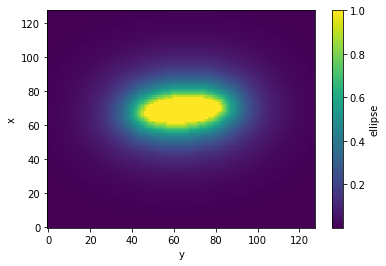

In [13]:
validation_ds['ellipse'][1, :, :].plot()
validation_ds[['maj_len', 'min_len']].sel(p=slice(0, 10))

In [14]:
model.predict(X_val[0:10, :, :, :])

1/1 [==============================] - 1s 556ms/step


array([[30.364735 , 16.196074 ],
       [36.039642 , 16.669176 ],
       [36.90883  ,  8.4563265],
       [27.59444  , 14.655761 ],
       [25.434114 ,  5.621972 ],
       [26.13206  ,  8.352343 ],
       [10.52188  ,  4.4188952],
       [26.868107 ,  3.0810454],
       [23.920158 ,  6.7062826],
       [36.01392  ,  1.2608857]], dtype=float32)

In [11]:
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(32, activation='relu'))
CNN_model.add(layers.Dense(2))

In [12]:
CNN_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [13]:
CNN_history = CNN_model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 4s 11ms/step - loss: 40.1368 - mse: 40.1368 - val_loss: 20.7311 - val_mse: 20.7311
Epoch 2/10
313/313 [==============================] - 3s 10ms/step - loss: 15.6836 - mse: 15.6836 - val_loss: 11.9389 - val_mse: 11.9389
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 9.9732 - mse: 9.9732 - val_loss: 6.2533 - val_mse: 6.2533
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 6.4853 - mse: 6.4853 - val_loss: 4.0679 - val_mse: 4.0679
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 4.6055 - mse: 4.6055 - val_loss: 3.2739 - val_mse: 3.2739
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 3.6927 - mse: 3.6927 - val_loss: 3.9771 - val_mse: 3.9771
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 3.2555 - mse: 3.2555 - val_loss: 3.0651 - val_mse: 3.0651
Epoch 8/10
313/313 [==============================] - 3s 10ms

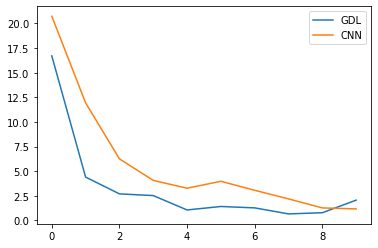

In [15]:
a = plt.plot(history.history['val_mse'], label='GDL')
b = plt.plot(CNN_history.history['val_mse'], label='CNN')
plt.legend()

In [16]:
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/test_data.nc")
X_test = tf.expand_dims(tf.convert_to_tensor(test_ds["ellipse"]), axis=-1)
Y_test = tf.convert_to_tensor(test_ds[['maj_len', 'min_len']].to_array().transpose())

In [17]:
model.evaluate(X_val, Y_val)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 20ms/step - loss: 2.0816 - mse: 2.0816


[2.0815536975860596, 2.0815536975860596]

In [18]:
CNN_model.evaluate(X_val, Y_val)
CNN_model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 37.9145 - mse: 37.9145


[37.91446304321289, 37.91446304321289]